<a href="https://colab.research.google.com/github/TomoharuKurosu/Tomoaharu_Kurosu_2023/blob/main/%E7%94%BB%E5%83%8F%E5%88%86%E6%9E%90%E3%80%80%E3%83%8F%E3%83%81%E3%81%A8%E3%82%A2%E3%83%AA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#アリとミツバチの区別ウ
%matplotlib inline


In [2]:
# License: BSD
# Author: Sasank Chilamkurthy

from __future__ import print_function, division

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy

plt.ion()   # interactive mode


In [3]:
%%shell

# hymenoptera_data をダウンロードします。
wget https://download.pytorch.org/tutorial/hymenoptera_data.zip
# data ディレクトリに解凍します。
mkdir ./data
unzip ./hymenoptera_data.zip -d ./data


--2024-05-10 07:47:36--  https://download.pytorch.org/tutorial/hymenoptera_data.zip
Resolving download.pytorch.org (download.pytorch.org)... 18.160.200.71, 18.160.200.112, 18.160.200.126, ...
Connecting to download.pytorch.org (download.pytorch.org)|18.160.200.71|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 47286322 (45M) [application/zip]
Saving to: ‘hymenoptera_data.zip’

hymenoptera_data.zi 100%[===================>]  45.10M   187MB/s    in 0.2s    

2024-05-10 07:47:36 (187 MB/s) - ‘hymenoptera_data.zip’ saved [47286322/47286322]

Archive:  ./hymenoptera_data.zip
   creating: ./data/hymenoptera_data/
   creating: ./data/hymenoptera_data/train/
   creating: ./data/hymenoptera_data/train/ants/
  inflating: ./data/hymenoptera_data/train/ants/0013035.jpg  
  inflating: ./data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg  
  inflating: ./data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg  
  inflating: ./data/hymenoptera_data/train/ants/1099

In [4]:
# トレーニングのためのデータの拡張と検証のための正規化のみ
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'data/hymenoptera_data'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


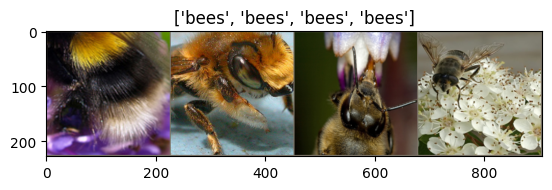

In [5]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # プロットが更新されるように少し一時停止します


# トレーニングデータのバッチを取得する
inputs, classes = next(iter(dataloaders['train']))

# バッチからグリッドを作成する
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


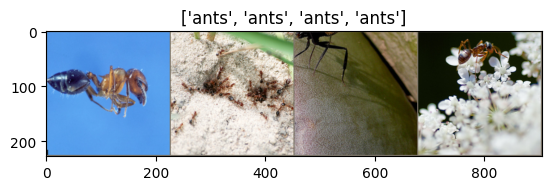

In [6]:
dataloaders_unshuffle = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=False, num_workers=4)
                         for x in ['train', 'val']}

# トレーニングデータのバッチを取得する
inputs, classes = next(iter(dataloaders_unshuffle['train']))

# バッチからグリッドを作成する
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])


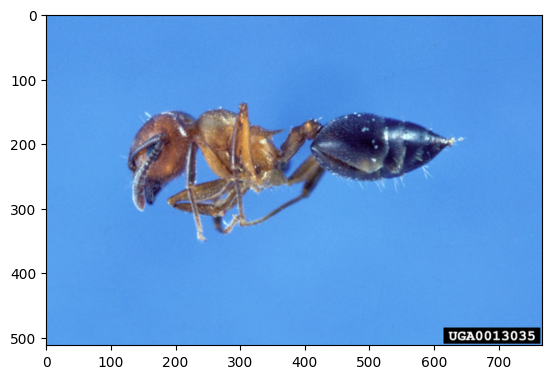

In [7]:
import matplotlib.image as mpimg
img = mpimg.imread('data/hymenoptera_data/train/ants/0013035.jpg')
plt.imshow(img)


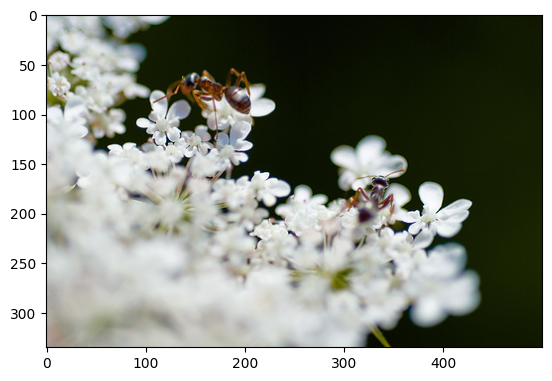

In [8]:
img = mpimg.imread('data/hymenoptera_data/train/ants/1030023514_aad5c608f9.jpg')
plt.imshow(img)
img = mpimg.imread('data/hymenoptera_data/train/ants/1095476100_3906d8afde.jpg')
plt.imshow(img)
img = mpimg.imread('data/hymenoptera_data/train/ants/1099452230_d1949d3250.jpg')
plt.imshow(img)


In [10]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # 各エポックにはトレーニングフェーズと検証フェーズがあります
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # モデルをトレーニングモードに設定します
            else:
                model.eval()   # モデルを評価モードに設定します

            running_loss = 0.0
            running_corrects = 0

            # データを繰り返し処理します。
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # 勾配をゼロにします。
                optimizer.zero_grad()

                # 順伝播
                # トレーニングの場合は履歴を追跡します
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # トレーニングの場合は逆伝播と最適化を行います
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # 評価
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # model を deepcopy します
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # 最適なモデルの重みをロードします。
    model.load_state_dict(best_model_wts)
    return model



In [11]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)


In [12]:
model_ft = models.resnet18(pretrained=True)
num_ftrs = model_ft.fc.in_features
# ここでは、各出力サンプルのサイズが2に設定されています。
# nn.Linear（num_ftrs、len（class_names））で汎用的にすることもできます。
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# 学習率を7エポックごとに0.1倍減算します
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 124MB/s]


In [14]:
import torch.nn as nn

# resnet18
(nn.Linear(in_features=512, out_features=1000, bias=True))

# model_ft
(nn.Linear(in_features=512, out_features=2, bias=True))


Linear(in_features=512, out_features=2, bias=True)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=25)


Epoch 0/24
----------


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(
/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


train Loss: 0.5259 Acc: 0.7090
val Loss: 0.4151 Acc: 0.8039

Epoch 1/24
----------
train Loss: 0.7188 Acc: 0.6885
val Loss: 0.4693 Acc: 0.7974

Epoch 2/24
----------
train Loss: 0.3881 Acc: 0.8443
val Loss: 0.2304 Acc: 0.9085

Epoch 3/24
----------
train Loss: 0.5206 Acc: 0.7951
val Loss: 0.3616 Acc: 0.8693

Epoch 4/24
----------
train Loss: 0.4067 Acc: 0.8074
val Loss: 0.3803 Acc: 0.9020

Epoch 5/24
----------
train Loss: 0.5141 Acc: 0.7828
val Loss: 0.2084 Acc: 0.9150

Epoch 6/24
----------
train Loss: 0.3861 Acc: 0.8361
val Loss: 0.3767 Acc: 0.8758

Epoch 7/24
----------
train Loss: 0.3724 Acc: 0.8361
val Loss: 0.2321 Acc: 0.9085

Epoch 8/24
----------
train Loss: 0.2378 Acc: 0.8975
val Loss: 0.2352 Acc: 0.9020

Epoch 9/24
----------
train Loss: 0.2602 Acc: 0.8607
val Loss: 0.2234 Acc: 0.9085

Epoch 10/24
----------
train Loss: 0.2813 Acc: 0.8811
val Loss: 0.1898 Acc: 0.9085

Epoch 11/24
----------
train Loss: 0.2337 Acc: 0.9139
val Loss: 0.2073 Acc: 0.9085

Epoch 12/24
----------
t

In [ ]:
visualize_model(model_ft)


In [ ]:
#転移学習
model_conv = torchvision.models.resnet18(pretrained=True)
for param in model_conv.parameters():
    param.requires_grad = False

# モジュールのパラメーターは、デフォルトでrequires_grad = True になっています
num_ftrs = model_conv.fc.in_features
model_conv.fc = nn.Linear(num_ftrs, 2)

model_conv = model_conv.to(device)

criterion = nn.CrossEntropyLoss()

# ファインチューニングと違い、最終層のパラメーターのみが最適化されます
optimizer_conv = optim.SGD(model_conv.fc.parameters(), lr=0.001, momentum=0.9)

# 学習率を7エポックごとに0.1倍減算します
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_conv, step_size=7, gamma=0.1)


In [ ]:
model_conv = train_model(model_conv, criterion, optimizer_conv,
                         exp_lr_scheduler, num_epochs=25)


In [ ]:
visualize_model(model_conv)

plt.ioff()
plt.show()
